In [1]:
!pip install datasets sentence-transformers scikit-learn

  Using cached datasets-3.0.2-py3-none-any.whl (472 kB)
  Using cached sentence_transformers-3.2.1-py3-none-any.whl (255 kB)
  Using cached scikit_learn-1.5.2-cp310-cp310-macosx_12_0_arm64.whl (11.0 MB)
  Using cached fsspec-2024.9.0-py3-none-any.whl (179 kB)
  Using cached PyYAML-6.0.2-cp310-cp310-macosx_11_0_arm64.whl (171 kB)
  Using cached pyarrow-17.0.0-cp310-cp310-macosx_11_0_arm64.whl (27.2 MB)
  Using cached filelock-3.16.1-py3-none-any.whl (16 kB)
  Using cached numpy-2.1.2-cp310-cp310-macosx_14_0_arm64.whl (5.4 MB)
  Using cached tqdm-4.66.5-py3-none-any.whl (78 kB)
  Using cached xxhash-3.5.0-cp310-cp310-macosx_11_0_arm64.whl (30 kB)
  Using cached huggingface_hub-0.26.1-py3-none-any.whl (447 kB)
  Using cached multiprocess-0.70.16-py310-none-any.whl (134 kB)
  Using cached aiohttp-3.10.10-cp310-cp310-macosx_11_0_arm64.whl (390 kB)
  Using cached dill-0.3.8-py3-none-any.whl (116 kB)
  Using cached requests-2.32.3-py3-none-any.whl (64 kB)
  Using cached pandas-2.2.3-cp310-cp3

# Task: Text Clustering with Custom KMeans

Using sentence_transformers, convert a set of texts into embeddings, and apply clustering using a custom implementation of KMeans. The goal is to group similar texts based on different distance metrics (such as cosine similarity, Euclidean distance, or Manhattan distance) implemented in the KMeans algorithm.

## 1. Data loading

Load the GO Emotions dataset from Hugging Face to obtain the texts that will be clustered. If you prefer some other dataset you can use it.

In [1]:
from datasets import load_dataset

dataset = load_dataset('google-research-datasets/go_emotions', split='train')


/Users/m.basov/Desktop/AITalentHub/LLM-course/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Print some examples

In [2]:
for i in range(5):
    print(f"Text {i+1}: {dataset[i]['text']}")

Text 1: My favourite food is anything I didn't have to cook myself.
Text 2: Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead
Text 3: WHY THE FUCK IS BAYLESS ISOING
Text 4: To make her feel threatened
Text 5: Dirty Southern Wankers


## 2. Convert texts to embeddings

Use the sentence-transformers library to transform the texts into embeddings (numerical vectors) for clustering.

In [3]:
docs = [entry['text'] for entry in dataset]

In [4]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer('cointegrated/rubert-tiny2')
embeddings = model.encode(docs, convert_to_tensor=True)
print(f"Shape of embeddings: {embeddings.shape}")

Shape of embeddings: torch.Size([43410, 312])


In [9]:
embeddings = embeddings.cpu().numpy()

## 3. Implement custom KMeans

Create a custom implementation of KMeans, supporting at leas four different distance metrics (Correlation, Euclidean, Cosine, Mahalanobis). You shouldn't use any specific libs, only numpy.
Here are the formulas for correlation distance and Mahalanobis distance:

#### Correlation Distance
Correlation distance measures the difference in the direction of vectors rather than their magnitude. The formula for correlation distance is:

$$
d_{\text{corr}}(a, b) = 1 - \frac{\sum_{i=1}^{n}(a_i - \bar{a})(b_i - \bar{b})}{\sqrt{\sum_{i=1}^{n}(a_i - \bar{a})^2} \sqrt{\sum_{i=1}^{n}(b_i - \bar{b})^2}}
$$

where:
- $a$ and $b$ are two vectors,
- $\bar{a}$ and $\bar{b}$ are the mean values of the components of vectors $a$ and $b$, respectively.

or using ```np.corrcoef```:

$$
d_{\text{corr}}(a, b) = 1 - np.corrcoef(a, b)[0,1]
$$


#### Mahalanobis Distance
Mahalanobis distance accounts for not only the distance between points but also the covariance between them. The formula is:

$$
d_{\text{mahal}}(a, b) = \sqrt{(a - b)^T S^{-1} (a - b)}
$$

where:
- $a$ and $b$ are two vectors,
- $S$ is the covariance matrix of the features,
- $S^{-1}$ is the inverse covariance matrix.


In [5]:
import numpy as np

def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

def cosine_distance(a, b):
    return 1 - (np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

def mahalanobis_distance(a, b, inv_cov_matrix):
    diff = a - b
    return np.sqrt(np.dot(np.dot(diff.T, inv_cov_matrix), diff))

def correlation_distance(a, b):
    return 1 - np.corrcoef(a, b)[0, 1]

Implement custom K-Means class

In [10]:
class CustomKMeans:
    def __init__(self, n_clusters=3, max_iter=100, distance_metric='euclidean', **kwargs):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.distance_metric = distance_metric
        self.centroids = None
        self.labels_ = None
        self.kwargs = kwargs

    def fit(self, X):
        random_indices = np.random.choice(len(X), self.n_clusters, replace=False)
        self.centroids = X[random_indices]

        for _ in range(self.max_iter):
            self.labels_ = np.array([self._assign_label(x) for x in X])
            new_centroids = np.array([
                X[self.labels_ == i].mean(axis=0) if len(X[self.labels_ == i]) > 0 else self.centroids[i] 
                for i in range(self.n_clusters)
            ])

            if np.all(self.centroids == new_centroids):
                break
            self.centroids = new_centroids

    def _assign_label(self, x):
        distances = []
        for centroid in self.centroids:
            if self.distance_metric == 'euclidean':
                distances.append(euclidean_distance(x, centroid))
            elif self.distance_metric == 'cosine':
                distances.append(cosine_distance(x, centroid))
            elif self.distance_metric == 'mahalanobis':
                distances.append(mahalanobis_distance(x, centroid, **self.kwargs))
            elif self.distance_metric == 'correlation':
                distances.append(correlation_distance(x, centroid))
        return np.argmin(distances)

## 4. Fit the custom K-Means

Fit the custom KMeans model to the dataset using all of the distance metrics and obtain cluster labels.

In [11]:
n_clusters = 10
cov_matrix = np.cov(embeddings, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

distance_metrics = ['correlation', 'euclidean', 'cosine', 'mahalanobis']
labels_dict = {}

for metric in distance_metrics:
    print(f"Fitting CustomKMeans with {metric} distance...")
    if metric == 'mahalanobis':
        custom_kmeans = CustomKMeans(n_clusters=n_clusters, distance_metric=metric, inv_cov_matrix=inv_cov_matrix)
    else:
        custom_kmeans = CustomKMeans(n_clusters=n_clusters, distance_metric=metric)
    
    custom_kmeans.fit(embeddings)
    labels_dict[metric] = custom_kmeans.labels_

for metric, labels in labels_dict.items():
    print(f"\nCustom KMeans labels with {metric} distance for the first 10 texts:")
    print(labels[:10])

Fitting CustomKMeans with correlation distance...
Fitting CustomKMeans with euclidean distance...
Fitting CustomKMeans with cosine distance...
Fitting CustomKMeans with mahalanobis distance...

Custom KMeans labels with correlation distance for the first 10 texts:
[0 6 3 7 3 3 5 9 8 2]

Custom KMeans labels with euclidean distance for the first 10 texts:
[1 4 5 3 5 6 7 2 2 9]

Custom KMeans labels with cosine distance for the first 10 texts:
[0 7 9 4 9 9 2 5 6 3]

Custom KMeans labels with mahalanobis distance for the first 10 texts:
[5 3 7 0 7 7 4 3 5 3]


## 5. Visualize the results

Visualize the clusters by reducing the dimensionality of the embeddings using PCA and plotting the clusters in 2D space.  
You should get something like this:

<a href="https://ibb.co/nRY9hQf"><img src="https://i.ibb.co/zNBpKPb/output.png" alt="output" border="0"></a>

In [12]:
!pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached matplotlib-3.9.2-cp310-cp310-macosx_11_0_arm64.whl (7.8 MB)
  Using cached kiwisolver-1.4.7-cp310-cp310-macosx_11_0_arm64.whl (64 kB)
  Using cached fonttools-4.54.1-cp310-cp310-macosx_11_0_arm64.whl (2.3 MB)
  Using cached contourpy-1.3.0-cp310-cp310-macosx_11_0_arm64.whl (249 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl (106 kB)

[notice] A new release of pip is available: 23.0.1 -> 24.3
[notice] To update, run: pip install --upgrade pip


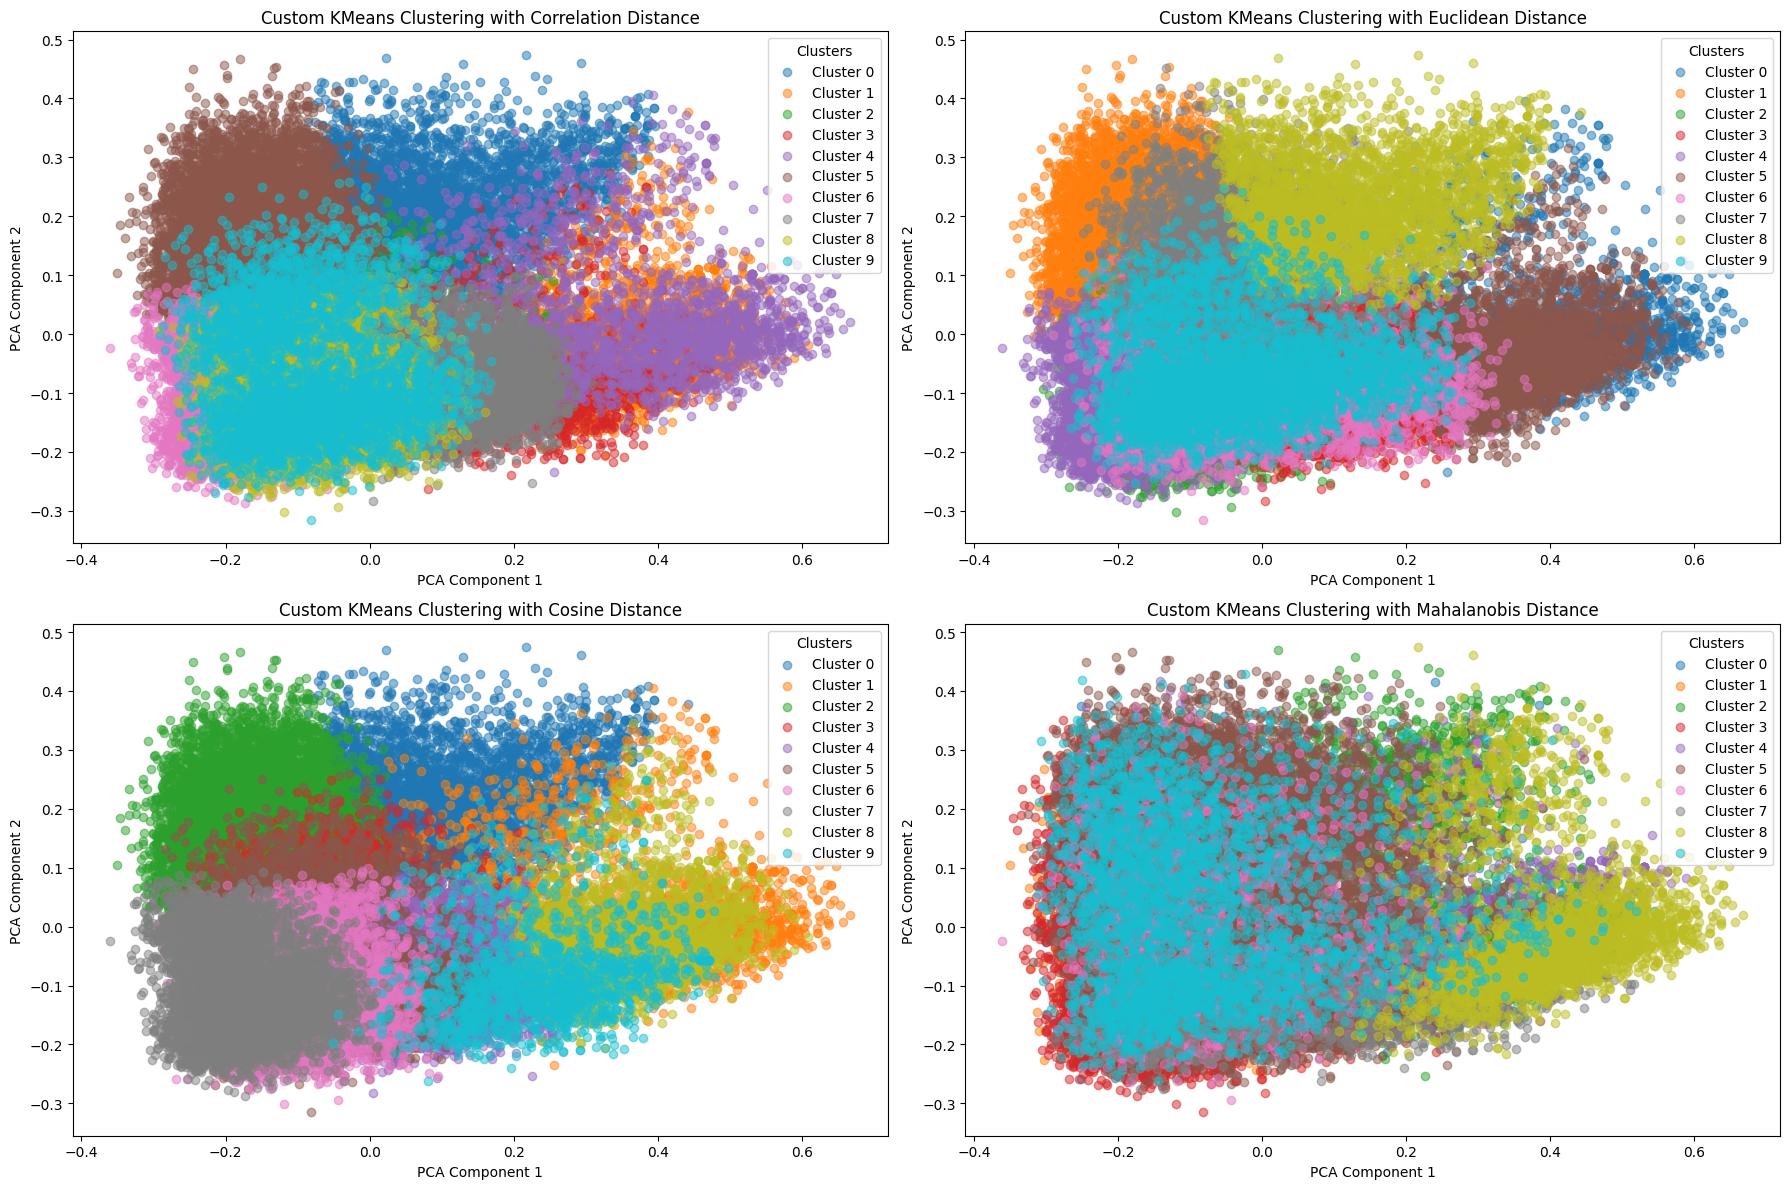

In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(18, 12))
for idx, metric in enumerate(distance_metrics):
    plt.subplot(2, 2, idx + 1)
    labels = labels_dict[metric]
    for label in range(10):
        cluster_points = reduced_embeddings[np.array(labels) == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {label}', alpha=0.5)
    
    plt.title(f"Custom KMeans Clustering with {metric.capitalize()} Distance")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title="Clusters", loc='upper right')

plt.tight_layout()
plt.show()

Let's print examples of the text for each cluster

In [14]:
for metric, labels in labels_dict.items():
    print(f"\n--- Sample Texts for Clusters Using {metric.capitalize()} Distance ---")
    
    for cluster in range(n_clusters):
        print(f"\nCluster {cluster}:")
        cluster_texts = [docs[i] for i in range(len(docs)) if labels[i] == cluster]
        for text in cluster_texts[:5]:
            print(f"- {text}")


--- Sample Texts for Clusters Using Correlation Distance ---

Cluster 0:
- My favourite food is anything I didn't have to cook myself.
- I miss them being alive
- When I feel down I listen to music.
- Thanks! I love watching him every week
- Thanks DB, I'll see if I can find the book

Cluster 1:
- Thank you friend
- Fucking coward.
- Super, thanks
- Happy to be able to help.
- You can always kneel.

Cluster 2:
- It might be linked to the trust factor of your friend.
- You are going to do the dishes now
- Your aunt has some damn nerve, though!
- It's a better option because it's my life and none of your business? Lmfao, who are you
- your mom likes to copy me cause she has no creativity just like you:

Cluster 3:
- WHY THE FUCK IS BAYLESS ISOING
- Dirty Southern Wankers
- OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015.
- WHAT ARE YOU DOIN [NAME]?
- [NAME] sees all

Cluster 4:
- aw, thanks! I appreciate that! 
- It's crazy how far Photo

## 6. Report

Make a conclusion and write a short report. What are the differnes between the methods used? What are their limitations? What is the applicability of each?

#### Краткий отчет по результатам кластеризации текстов с использованием разных метрик расстояний

1. **Корреляционное расстояние**: используется для измерения схожести между векторами, фокусируясь на их направлении, а не на величине.
   - **Результаты**: объединяет тексты с похожим эмоционалом, но не всегда одинаковой тематикой. Например: тексты о личных переживаниях и недовольстве.
   - **Применение**: задачи, где важна относительная форма данных, например, анализ эмоционального настроения.

2. **Евклидово расстояние**: измеряет "обычное" расстояние между точками в пространстве.
   - **Результаты**: кластеры ориентированы на тексты, схожие по интенсивности эмоций и длине, однако намного менее однородны (из-за чувствительности к масштабу).
   - **Применение**: задачи, где важны абсолютные различия, например, какой-нибудь анализ отзывов с количественными оценками.

3. **Косинусное расстояние**: измеряет угол между векторами, игнорируя их длину.
   - **Результаты**: объединяет тексты по тематике и стилю, игнорируя абсолютные значения. Кластеры показали хороший баланс между содержательной и тематической группировкой.
   - **Применение**: идеально для текстового анализа в задачах кластеризации, например, при суммаризации комментариев или постов.

4. **Расстояние Махаланобиса**: учитывает ковариацию между переменными, что позволяет учитывать корреляции между признаками.
   - **Результаты**: компактные кластеры с текстами, имеющими взаимосвязанные признаки. Метрика показала лучшие результаты при наличии взаимосвязей между словами и темами.
   - **Применение**: думаю, может быть эффективна для сложных текстовых данных с взаимозависимыми признаками, например, в анализе сообщений с контекстуальными связями.